
##**ナイーブベイズ分類器**  


### 始めに
本記事では、ナイーブベイズ分類器の動作原理をまず理解し、その数式を導出する背景理論についても追加で理解を深めます。

ナイーブベイズ（naive Bayes）分類器は、ベイズの定理を用いて作られた確率分類器の一種です。

ナイーブベイズ分類器を理解するためには、ベイズの定理の数式よりも、ベイズの定理の哲学をしっかりと理解することが重要です。

本記事をよりよく理解するためには、以下の内容について知っておくと良いでしょう。

- **尤度に関する理論**: 最大尤度法の紹介編
- **ベイズの定理**に関する知識

### 分類の確率的判断の根拠を探して
#### 事前知識を利用した分類: prior
確率的な背景知識を持ちながら特別な追加情報なしにサンプルを分類する例を考えてみましょう。

たとえば、誰かを何の情報もなしに、その人が男性か女性かを分類しろと言われたらどう考えますか？

世の中の半分は男性で、半分は女性だと考えれば、50%の確率で推測するしかありません。

また、ランダムにどちらかの性別を答えるしかないでしょう。

しかし、たとえば三毛猫を連れてきて、その猫がメスかオスかを尋ねられたとしましょう。

理由は詳しく知らなくても、三毛猫は性染色体の関係でほとんどがメスだと知られています。

そうすると、三毛猫を見たら高い確率でメスだと考えるのではないでしょうか？



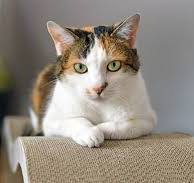

**図1. 性染色体の関係で三毛猫は99%がメスと知られている**


このように、テストデータサンプルに対するいかなる情報（つまり、特徴量）がなくても、事前知識だけでテストデータサンプルを判別することができます。そして、このような判別に役立つ確率値を事前確率（prior probability）と呼びます。

なお、この事前確率は実際のデータではトレーニングデータからクラス間の比率を使って事前に計算することができます。

たとえば、100件のトレーニングデータで30:30:40の比率でクラスA, B, Cが与えられている場合、各クラスの事前確率は0.3, 0.3, 0.4になります。

#### 特定情報が追加される場合: 尤度
身長（特定の情報）に基づいて、その人が男性か女性かを判別する問題を考えてみましょう。

トレーニングサンプルを通じて、次のように男性と女性の身長の分布が異なることが分かっているとします。



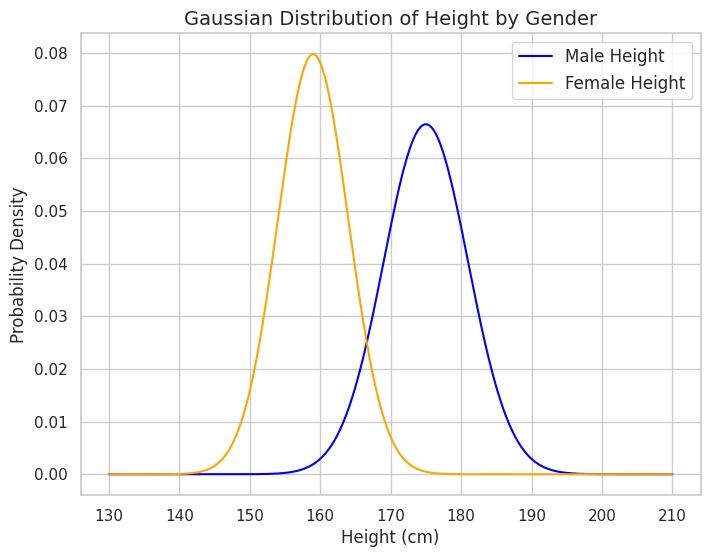

In [8]:
from scipy.stats import norm

# Male and female height mean and standard deviation
male_mean, male_std = 175, 6
female_mean, female_std = 159, 5

# X values for plotting the Gaussian distribution
x_values = np.linspace(130, 210, 1000)

# Gaussian distribution for male and female heights
male_pdf = norm.pdf(x_values, male_mean, male_std)
female_pdf = norm.pdf(x_values, female_mean, female_std)

# Plot the Gaussian curves
plt.figure(figsize=(8, 6))
plt.plot(x_values, male_pdf, label="Male Height", color="blue")
plt.plot(x_values, female_pdf, label="Female Height", color="orange")

# Labels in English
plt.xlabel('Height (cm)', fontsize=12)
plt.ylabel('Probability Density', fontsize=12)
plt.legend(loc='upper right', fontsize=12)
plt.title('Gaussian Distribution of Height by Gender', fontsize=14)

# Show the plot
plt.show()




**図2. トレーニングサンプルを通じて得られた男性、女性の身長確率分布**



このとき、分類しようとしている人の身長が175cmだとした場合、構築された確率密度関数の分布はどのようになるでしょうか？



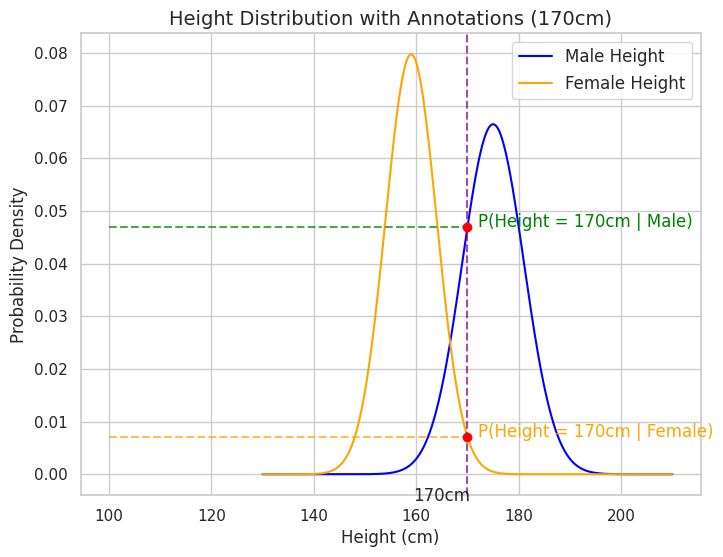

In [18]:
# Set the height value to 170cm instead of 175cm
height_val = 170
male_prob = norm.pdf(height_val, male_mean, male_std)
female_prob = norm.pdf(height_val, female_mean, female_std)

# Plot the Gaussian curves
plt.figure(figsize=(8, 6))
plt.plot(x_values, male_pdf, label="Male Height", color="blue")
plt.plot(x_values, female_pdf, label="Female Height", color="orange")

# Plot vertical line for height = 170cm
plt.axvline(x=height_val, color='purple', linestyle='--', alpha=0.7)

# Plot horizontal lines for probabilities
plt.hlines(male_prob, xmin=100, xmax=height_val, colors='green', linestyle='--', alpha=0.7)
plt.hlines(female_prob, xmin=100, xmax=height_val, colors='orange', linestyle='--', alpha=0.7)

# Mark points on the graph
plt.scatter([height_val], [male_prob], color='red', zorder=5)
plt.scatter([height_val], [female_prob], color='red', zorder=5)

# Add text annotations in plain text
plt.text(height_val + 2, male_prob, 'P(Height = 170cm | Male)', color="green", fontsize=12)
plt.text(height_val + 2, female_prob, 'P(Height = 170cm | Female)', color="orange", fontsize=12)

# Annotations for 170cm label
plt.text(height_val - 5, -0.005, "170cm", fontsize=12, ha='center')

# Labels and title
plt.xlabel('Height (cm)', fontsize=12)
plt.ylabel('Probability Density', fontsize=12)
plt.legend(loc='upper right', fontsize=12)
plt.title('Height Distribution with Annotations (170cm)', fontsize=14)

# Display the plot
plt.show()


**図3. 事前に構築しておいた男性、女性の身長確率分布にテストデータサンプルの値を代入した場合**



図3から、女性よりも男性だと考える方が「可能性」が高いとわかります。

ここでいう「可能性」は、最大尤度法の紹介編で説明した「尤度の貢献度」です。

今回の例では、特徴情報が1つしかないため、この「尤度の貢献度」をそのまま尤度と考えます。

この尤度は次のように考えることができます。

男性だと判断した場合の身長が175cmである尤度は次のように表せます。

$$
P(\text{身長} = 175\text{cm} | \text{性別} = \text{男性}) \quad \tag{1}
$$

一方、女性だと判断した場合の身長が175cmである尤度は次のように表せます。

$$
P(\text{身長} = 175\text{cm} | \text{性別} = \text{女性}) \quad \tag{2}
$$

今回の例では、式(1)と式(2)の2つの尤度の値が次のようであることもわかりました。

$$
P(\text{身長} = 175\text{cm} | \text{性別} = \text{男性}) > P(\text{身長} = 175\text{cm} | \text{性別} = \text{女性}) \quad \tag{3}
$$

式 (3) から、このテストデータの人が男性だと判断する良い根拠であることが容易に理解できます。

### 情報がさらに追加される場合は？
情報がさらに追加されたらどうするべきでしょうか？

たとえば、身長だけでなく体重に関する情報も追加されたと考えてみましょう。

これまで事前情報（prior）に追加情報（尤度）を掛けて更新してきたように、その後も追加情報をどんどん掛け合わせればよいのです。
続きの翻訳を以下に示します。

---

たとえば、前述のテストデータの人の体重が80kgだった場合、判断の根拠は次のように更新できます。

男性だと判断する場合の判断根拠は

$$
P(\text{性別} = \text{男性}) \times P(\text{身長} = 175\text{cm} | \text{性別} = \text{男性}) \times P(\text{体重} = 80\text{kg} | \text{性別} = \text{男性}) \quad \tag{6}
$$

一方、女性だと判断する場合の判断根拠は

$$
P(\text{性別} = \text{女性}) \times P(\text{身長} = 175\text{cm} | \text{性別} = \text{女性}) \times P(\text{体重} = 80\text{kg} | \text{性別} = \text{女性}) \quad \tag{7}
$$

この2つの判断根拠を比較することで、男性か女性かを決定できます。

### 背景理論の紹介
前述の内容は、しっかりとした理論的根拠に基づいています。

ベイズの定理を用いて説明すると、数式が複雑に見えるため、その内容は後半に移しました。ベイズの定理に関しては、以下の記事を参照してください。

- **Bayes’ Ruleに関する内容**: ベイズ定理の意味編

今回の記事のこの節では、ベイズの定理の根本的な意味よりも、数式的な展開を通じて、上で説明した「判断根拠」が導出される過程を把握します。

### ベイズの定理を通じた「判断根拠」の導出
結論から言えば、私たちが実際に求めるのは、このデータを見たときにそのデータがどのクラスに属するかを判断することであり、その判断根拠は確率から得られます。

たとえば、2つのクラス $c_1, c_2$ と与えられたデータ $x$ について、次のような事後確率からデータのクラスを判断できます。

$$
P(c_i | x) \quad \text{for } i = 1, 2 \quad \tag{8}
$$

つまり、もし $P(c_1 | x) > P(c_2 | x)$ であれば、このサンプルのラベルは $c_1$ であり、そうでなければ $c_2$ です。

これを数式で表現すると次のようになります。

$$
P(c_1 | x) > ? P(c_2 | x) \quad \tag{9}
$$

ここで、$A > ? B$ は「AがBより大きいか？」という意味です。

この式(9)にベイズの定理を適用すると次のようになります。

$$
\frac{P(x | c_1) P(c_1)}{p(x)} > ? \frac{P(x | c_2) P(c_2)}{p(x)} \quad \tag{10}
$$

式 (10) を詳しく見ると、比較する2つの確率値の分母が同じです。

したがって、$p(x)$ の値が何であれ、クラス判断に対する結果は変わらないため無視できます。

そのため、式 (10) から分母を除いた値でもクラスを判断できます。

$$
P(x | c_1) P(c_1) > ? P(x | c_2) P(c_2) \quad \tag{11}
$$

### データの特徴量が複数ある場合
複数の特徴量を持つデータでクラス $c_i$ を判断するには、数式がやや複雑になります。

つまり、各データに対してクラス $i = 1, 2, \ldots, k$ について、$P(c_i | x)$ の代わりに $P(c_i | x_1, x_2, \ldots, x_n)$ を比較することになります。

たとえば、クラスが $c_1, c_2$ の2つだけあり、n個の特徴量が与えられる場合、式 (9) と同様の数式は次のようになります。

$$
P(c_1 | x_1, x_2, \ldots, x_n) > ? P(c_2 | x_1, x_2, \ldots, x_n) \quad \tag{12}
$$

ここで、$P(c_1 | x_1, x_2, \ldots, x_n)$ をさらに展開すると次のようになります。

$$
P(c_1 | x_1, x_2, \ldots, x_n) = P(c_1) P(x_1 | c_1) P(x_2 | c_1, x_1) P(x_3 | c_1, x_1, x_2) \ldots P(x_n | c_1, x_1, x_2, \ldots, x_{n-1}) \quad \tag{13}
$$

ここで、特徴量はすべて独立して抽出されると仮定しましょう。

（そのため、このようなプロセスを経る分類器を「naive」Bayesと呼びます。）

したがって、たとえば $P(x_2 | c_1, x_1)$ は次のように表せます。

$$
P(x_2 | c_1, x_1) = P(x_2 | c_1) \quad \tag{14}
$$

つまり、$x_1$ が発生するかどうかにかかわらず、$x_2$ の確率は $x_1$ の発生の有無に条件として影響されないということです。

このようにして、式 (13) を次のように書き換えます。

$$
P(c_1 | x_1, x_2, \ldots, x_n) = P(c_1) P(x_1 | c_1) P(x_2 | c_1) P(x_3 | c_1) \ldots P(x_n | c_1) = P(c_1) \prod_{i=1}^{n} P(x_i | c_1) \quad \tag{15}
$$

このような方式で、式 (6) または式 (7) の「判断根拠」を導出することが可能です。

つまり、ナイーブベイズ分類器を使用すると、予測されたクラス $\hat{y}$ は次のようになります。

$$
\hat{y} = \arg\max_{k \in \{1, 2, \ldots, k\}} P(c_k) \prod_{i=1}^{n} P(x_i | c_k) \quad \tag{16}
$$

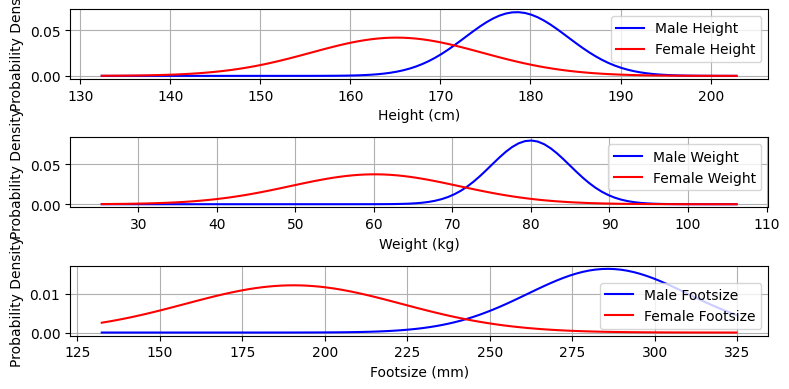

この人は女性です。


In [4]:
import numpy as np
import matplotlib.pyplot as plt

# データの定義
data = {
    'gender': ['male', 'male', 'male', 'male', 'female', 'female', 'female', 'female'],
    'height': np.array([6, 5.92, 5.58, 5.92, 5, 5.5, 5.42, 5.75]) * 30.48,  # feet to cm
    'weight': np.array([180, 190, 170, 165, 100, 150, 130, 150]) * 0.453592,  # lbs to kg
    'footsize': np.array([12, 11, 12, 10, 6, 8, 7, 9]) * 25.4  # inch to mm
}

person = {
    'height': 6 * 30.48,
    'weight': 130 * 0.453592,
    'footsize': 8 * 25.4
}

# データから事前確率を計算
n_male = data['gender'].count('male')
n_female = data['gender'].count('female')

total_ppl = len(data['gender'])

P_male = n_male / total_ppl
P_female = n_female / total_ppl

# 平均と分散の計算
idx_male = np.array(data['gender']) == 'male'
idx_female = np.array(data['gender']) == 'female'

# 男性の平均と分散
male_height_mean = np.mean(data['height'][idx_male])
male_weight_mean = np.mean(data['weight'][idx_male])
male_footsize_mean = np.mean(data['footsize'][idx_male])

male_height_var = np.var(data['height'][idx_male], ddof=1)
male_weight_var = np.var(data['weight'][idx_male], ddof=1)
male_footsize_var = np.var(data['footsize'][idx_male], ddof=1)

# 女性の平均と分散
female_height_mean = np.mean(data['height'][idx_female])
female_weight_mean = np.mean(data['weight'][idx_female])
female_footsize_mean = np.mean(data['footsize'][idx_female])

female_height_var = np.var(data['height'][idx_female], ddof=1)
female_weight_var = np.var(data['weight'][idx_female], ddof=1)
female_footsize_var = np.var(data['footsize'][idx_female], ddof=1)

# ガウス分布関数
def gaussian(x, mu, var):
    return 1 / np.sqrt(2 * np.pi * var) * np.exp(-((x - mu) ** 2) / (2 * var))

# 視覚化
plt.figure(figsize=(8, 4))

# Height
xx = np.linspace(min(data['height']) - 20, max(data['height']) + 20, 100)
plt.subplot(3, 1, 1)
plt.plot(xx, gaussian(xx, male_height_mean, male_height_var), label='Male Height', color='blue')
plt.plot(xx, gaussian(xx, female_height_mean, female_height_var), label='Female Height', color='red')
plt.xlabel('Height (cm)')
plt.ylabel('Probability Density')
plt.legend()
plt.grid()

# Weight
xx = np.linspace(min(data['weight']) - 20, max(data['weight']) + 20, 100)
plt.subplot(3, 1, 2)
plt.plot(xx, gaussian(xx, male_weight_mean, male_weight_var), label='Male Weight', color='blue')
plt.plot(xx, gaussian(xx, female_weight_mean, female_weight_var), label='Female Weight', color='red')
plt.xlabel('Weight (kg)')
plt.ylabel('Probability Density')
plt.legend()
plt.grid()

# Footsize
xx = np.linspace(min(data['footsize']) - 20, max(data['footsize']) + 20, 100)
plt.subplot(3, 1, 3)
plt.plot(xx, gaussian(xx, male_footsize_mean, male_footsize_var), label='Male Footsize', color='blue')
plt.plot(xx, gaussian(xx, female_footsize_mean, female_footsize_var), label='Female Footsize', color='red')
plt.xlabel('Footsize (mm)')
plt.ylabel('Probability Density')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

# 条件付き確率関数
def p_x_given_y(x, mean_y, variance_y):
    return 1 / np.sqrt(2 * np.pi * variance_y) * np.exp(-(x - mean_y) ** 2 / (2 * variance_y))

# ポスターリオ確率の計算
posterior_male = P_male * \
    p_x_given_y(person['height'], male_height_mean, male_height_var) * \
    p_x_given_y(person['weight'], male_weight_mean, male_weight_var) * \
    p_x_given_y(person['footsize'], male_footsize_mean, male_footsize_var)

posterior_female = P_female * \
    p_x_given_y(person['height'], female_height_mean, female_height_var) * \
    p_x_given_y(person['weight'], female_weight_mean, female_weight_var) * \
    p_x_given_y(person['footsize'], female_footsize_mean, female_footsize_var)

# 判定
if posterior_male > posterior_female:
    print('この人は男性です。')
else:
    print('この人は女性です。')
